# Fault Geometry Schematic
This jupyter notebook intends to collect short codes that plot a sign distance function geometry in the domain space 

In [1]:
import os, sys, time
import numpy as np
from scipy.interpolate import RectBivariateSpline
from sklearn.metrics.pairwise import euclidean_distances


import matplotlib.pylab as plt
plt.rc('text',usetex=True)
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

sys.path.insert(0,"/home/nico/Documents/TEAR/Codes_TEAR/PythonCodes/LibFolder")
from Lib_GeneralFunctions import *

In [2]:
# Sigmoid or any function of interest to represent the center of the fault / Zero level set function
def func(x, k=-0.0002, amp = 2.0):
    fx = amp * (x - x * k) / (k - abs(x) * 2.0 * k + 1.0)
    return fx

# The respective derivative ofthe previous zero level set function
def func_der(x, k=-0.0002, amp = 2.0):
    fx_prime = amp * (1 - k * k) / ((k - abs(x) * 2.0 * k + 1.0)*(k - abs(x) * 2.0 * k + 1.0))
    return fx_prime


# Sigmoid or any function of interest to represent the center of the fault / Zero level set function
def Tiltfunc(x, k=-0.0002, amp = 2.0, theta = 45*np.pi/180):
    fx = x*np.tan(theta)
    return fx


In [3]:
# Tangent vector for a given derivative
def TangentVector(fPrimeX, **kwargs):
    mag = np.sqrt(1.0 + fPrimeX * fPrimeX)
    
    TangentX = 1.0/mag
    TangentY = fPrimeX/mag
    return TangentX, TangentY

# Normal vector for a given derivative
def NormalVector(fPrimeX, **kwargs):
    mag = np.sqrt(1.0 + fPrimeX * fPrimeX)
    
    NormalX = -fPrimeX/mag
    NormalY = 1.0/mag
    
    return NormalX, NormalY

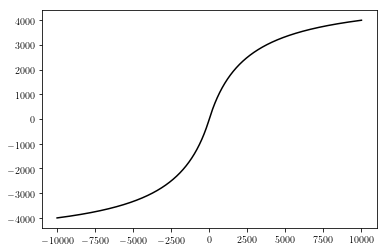

In [4]:
# Mesh definition

x = np.arange(-10000.0, 10000.0, 10)
y = np.arange(-10000.0, 10000.0, 10)
Nx = len(x)
Ny = len(y)
X, Y = np.meshgrid(x, y)

# fault geometry span definition
xx = np.linspace(-1.e4, 1.e4, 6001)
plt.plot(xx,func(xx),"k-")

In [5]:
def GetListCoords_FaultGeometry(xx):
    return list(map(list,zip(xx,func(xx))))

def GetClosestIndex(Coordx, Coordy, FaultNodes_CoordList):
    IndexMin = np.argmin(euclidean_distances(FaultNodes_CoordList,[[Coordx,Coordy]]))
    return IndexMin


FaultNodes_CoordList = GetListCoords_FaultGeometry(xx)


# idx Fields
idxField_full = np.array([[GetClosestIndex(X[j,i], Y[j,i], FaultNodes_CoordList) for i in range(Nx)] for j in range(Ny)])

In [6]:
# Sigmoid field
def get_SDF(xCoord,yCoord,idx,xArray):
    return euclidean_distances([[xCoord,yCoord]],[[xArray[idx],func(xArray[idx])]])[0][0]

SDF_Matrix = np.array([[get_SDF(X[j,i], Y[j,i],idxField_full[j,i],xx) for i in range(Nx)] for j in range(Ny)])


In [7]:
SigmoidDistMaskedOut = np.ma.masked_where(SDF_Matrix > 550, SDF_Matrix) 

In [8]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.lines as mlines
from palettable.scientific.sequential import GrayC_20_r
from matplotlib.cm import register_cmap
from matplotlib.ticker import AutoMinorLocator

cmap = LinearSegmentedColormap.from_list("cont",GrayC_20_r.mpl_colors[11:])


In [9]:
def PlotDomainCmap(CoorX, CoorY, Field, FieldName, cmap, getAx = False, figsize = (6, 6),dpi=100):
    try:
      fig = plt.figure(figsize = figsize, constrained_layout=True,dpi=dpi)
      gs = fig.add_gridspec(1, 1)
      ax = fig.add_subplot(gs[:, :])
    except:
      fig = plt.figure(figsize = figsize)
      ax = fig.add_subplot(1,1,1)
    ax.set_title("{FName}".format(FName = FieldName[0]),fontsize='large')
    ax.set_xlabel("X-Coordinate [m]"), ax.set_ylabel("Y-Coordinate [m]")
    ax.set_aspect('equal', 'box')
    img = ax.pcolormesh(CoorX, CoorY, Field, cmap = cmap)
    
    cbar = fig.colorbar(img, shrink=.5,orientation="horizontal")
    cbar.ax.set_xlabel(FieldName[1])
    
    return (fig, img, ax) if getAx else (fig, img)

def QuiverPlot(FaultDataObj):
    
    formatSpecs = {"width":0.006,"scale":1/0.05}
    Normalkwargs = dict(**{"color": "grey"},**formatSpecs)
    Tangentkwargs = dict(**{"color": "k"},**formatSpecs)
    
    CoorX,CoorY = FaultDataObj.GetReceiverCoords()[0],FaultDataObj.GetReceiverCoords()[1]
    n = plt.quiver(CoorX,CoorY ,FaultDataObj.Normal[0],FaultDataObj.Normal[1], **Normalkwargs)
    t = plt.quiver(CoorX,CoorY ,FaultDataObj.Tangent[0],FaultDataObj.Tangent[1],**Tangentkwargs)
    plt.quiverkey(n, .95, .9, 1, r'$\boldsymbol{n}$', color='grey', labelpos='W',zorder=120)
    plt.quiverkey(t, .95, .83, 1, r'$\boldsymbol{t}$', color='k', labelpos='W',zorder=120)
    
    TCoorX,TCoorY = FaultDataObj.GetTwinReceiverCoords()[0],FaultDataObj.GetTwinReceiverCoords()[1]
    plt.quiver(TCoorX,TCoorY ,FaultDataObj.Normal[0],FaultDataObj.Normal[1],**Normalkwargs)
    plt.quiver(TCoorX,TCoorY ,FaultDataObj.Tangent[0],FaultDataObj.Tangent[1],**Tangentkwargs)
    
def annotate_dim(ax,xyfrom,xyto,text=None, colorName = "gold"):

    if text is None:
        text = str(np.sqrt( (xyfrom[0]-xyto[0])**2 + (xyfrom[1]-xyto[1])**2 ))
    
    
    
    ax.annotate("",xyfrom,xyto,arrowprops=dict(arrowstyle='<|-|>',color=colorName))    
    ax.text((xyto[0]+xyfrom[0])/2,(xyto[1]+xyfrom[1])/2,text,fontsize=20,color = colorName)

In [10]:
def FindDistIndx(DistOfInterest, xArray, centerIdx:int):
    Distance = 0.0
    for i in range(centerIdx,len(xArray)):
        Distance += euclidean_distances([[xArray[i+1],func(xArray[i+1])]],
                                        [[xArray[i],func(xArray[i])]]
                                        )[0][0]
        if(Distance>DistOfInterest):
            break
    return i
       

In [11]:
class FaultData:
    def __init__(self, LocOfInterest, HalfThickness, Xval, Fxval, FxPrimeVal):
        self.DistAlongFault = LocOfInterest
        self.HalfThickness = HalfThickness
        self.Xval = Xval
        self.Fxval = Fxval
        self.FxPrimeVal = FxPrimeVal
        
        self.Normal = np.array(NormalVector(self.FxPrimeVal))
        self.Tangent = np.array(TangentVector(self.FxPrimeVal))
        
        self.RecSide1X = self.Xval + (np.array(NormalVector(self.FxPrimeVal))*Thickness)[0]
        self.RecSide1Y = self.Fxval + (np.array(NormalVector(self.FxPrimeVal))*Thickness)[1]
        self.RecSide2X = self.Xval - (np.array(NormalVector(self.FxPrimeVal))*Thickness)[0]
        self.RecSide2Y = self.Fxval - (np.array(NormalVector(self.FxPrimeVal))*Thickness)[1]
        
        
        self.Time = []
        self.Slip = []
        self.SlipRate = []
        
    def __repr__(self):
        return "FaultData Object, distance {} - half thickness {}".format(self.DistAlongFault, self.HalfThickness)
    
    def __str__(self):
        return "Fault Data at distance {}, half thickness {}".format(self.DistAlongFault, self.HalfThickness)
    
    def GetReceiverCoords(self):
        return [self.RecSide1X, self.RecSide1Y]
    
    def GetTwinReceiverCoords(self):
        return [self.RecSide2X, self.RecSide2Y]
    
    def appendFaultValues(self, time, Slip, SlipRate):
        self.Time.append(time)
        self.Slip.append(Slip)
        self.SlipRate.append(SlipRate)
        
    def ExtractTangentFieldComponentDiff(self, SplineFunctionPair):
        SetCoords1 = [self.RecSide1X, self.RecSide1Y]
        SetCoords2 = [self.RecSide2X, self.RecSide2Y]
        
        Comp1X, Comp1Y = GetLocData(SetCoords1, SplineFunctionPair)
        Comp2X, Comp2Y = GetLocData(SetCoords2, SplineFunctionPair)
        
        TanDisp1 = self.Tangent[0]*Comp1X + self.Tangent[1]*Comp1Y 
        TanDisp2 = self.Tangent[0]*Comp2X + self.Tangent[1]*Comp2Y 
        
        return TanDisp1 - TanDisp2
        
    
    # Tangent vector for a given derivative
    def TangentVector(fPrimeX, **kwargs):
        mag = np.sqrt(1.0 + fPrimeX * fPrimeX)

        TangentX = 1.0/mag
        TangentY = fPrimeX/mag
        return TangentX, TangentY

    # Normal vector for a given derivative
    def NormalVector(fPrimeX, **kwargs):
        mag = np.sqrt(1.0 + fPrimeX * fPrimeX)

        NormalX = -fPrimeX/mag
        NormalY = 1.0/mag

        return NormalX, NormalY
    
def Init_ListFaultDataObj(Thickness, LocOfInterest, XArray, FXArray, FXPrimeArray, centerIdx = 3000):
    idx_Interest = [FindDistIndx(DistOfInterest = a, xArray = XArray, centerIdx = centerIdx) for a in LocOfInterest]

    ListFaultDataObj = [FaultData(LocOfInterest[i], Thickness, xx[idx_Interest[i]], FXArray[idx_Interest[i]], 
                                  FXPrimeArray[idx_Interest[i]]) for i in range(len(idx_Interest))]
    
    return ListFaultDataObj

def TransposeListOfCoordinates(List2D):
    return np.array(List2D).T.tolist()

In [12]:
LocOfInterest = [2000,4000,6000,8000]
Thickness = 500
ListFaultDataObj = Init_ListFaultDataObj(Thickness, LocOfInterest, xx, func(xx), func_der(xx))

In [13]:
CoordinatesList = TransposeListOfCoordinates([CoorPoint.GetReceiverCoords() for CoorPoint in ListFaultDataObj])

TwinCoordinatesList = TransposeListOfCoordinates([CoorPoint.GetTwinReceiverCoords() for CoorPoint in ListFaultDataObj])

In [14]:
idx_Interest = [FindDistIndx(DistOfInterest = a, xArray = xx, centerIdx = 3000)for a in LocOfInterest]

# Fancy plotting tilted case

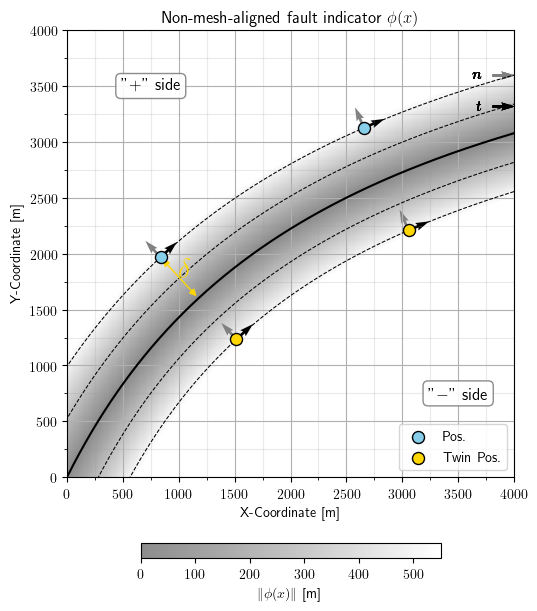

In [15]:
fig, img = PlotDomainCmap(X, Y, SigmoidDistMaskedOut, 
           ["Non-mesh-aligned fault indicator $\phi(x)$", "$\|\phi(x)\|$ [m]"],
           cmap)
plt.plot(xx,func(xx),"k-")
   
plt.contour(X,Y,SigmoidDistMaskedOut,levels=np.linspace(-Thickness, Thickness, 5, endpoint=True), colors="k", linestyles="--",linewidths=0.75)


MarkerSpecs = {"marker":".","facecolors":"skyblue","edgecolors":"k","s":300,"zorder":9,"label":"Pos."}
plt.scatter(CoordinatesList[0],CoordinatesList[1], **MarkerSpecs)
MarkerSpecs.update({"facecolors":"gold","label":"Twin Pos."})
plt.scatter(TwinCoordinatesList[0],TwinCoordinatesList[1], **MarkerSpecs)

plt.xlim(0,4000)
plt.ylim(0,4000)

plt.legend(loc="lower right")

#%%%%%%%%%%%%%%%% Grid plot %%%%%%%%%%%%%%%%%%%%%%%%%%

ax = fig.gca()
plt.grid(b=True, which='major' )

minor_locator = AutoMinorLocator(2)
ax.xaxis.set_minor_locator(minor_locator)
ax.yaxis.set_minor_locator(minor_locator)

plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
#%%%%%%%%%%%%%%%% END: Grid plot %%%%%%%%%%%%%%%%%%%%%%%%%%

[QuiverPlot(FaultDataObj) for FaultDataObj in ListFaultDataObj]

#%%%%%%%%%%%%%%%% Distance \delta %%%%%%%%%%%%%%%%%%%%%%%%%%

annotate_dim(ax,
             [xx[idx_Interest][0],func(xx[idx_Interest][0])],
             [CoordinatesList[0][0],CoordinatesList[1][0]],
             text="$\delta$")

#%%%%%%%%%%%%%%%% END: Distance \delta %%%%%%%%%%%%%%%%%%%%%%%%%%

#%%%%%%%%%%%%%%%% +/- side of the fault %%%%%%%%%%%%%%%%%%%%%%%%%%
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
ax.text(750, 3500, '"$+$" side', ha="center", va="center", size=12,
        bbox=bbox_props)
ax.text(3500, 750, '"$-$" side', ha="center", va="center", size=12,
        bbox=bbox_props)
#%%%%%%%%%%%%%%%% END: +/- side of the fault %%%%%%%%%%%%%%%%%%%%%%%%%%

plt.show()

# Tilted plotting

In [16]:
LocOfInterest = [2000,4000,6000,8000]
Thickness = 500.1
thetadeg = 60
ListFaultDataObj = Init_ListFaultDataObj(Thickness, LocOfInterest, xx, 
                                         Tiltfunc(xx,theta = thetadeg*np.pi/180), Tiltfunc(xx,theta = thetadeg*np.pi/180)/xx)

CoordinatesList = TransposeListOfCoordinates([CoorPoint.GetReceiverCoords() for CoorPoint in ListFaultDataObj])

TwinCoordinatesList = TransposeListOfCoordinates([CoorPoint.GetTwinReceiverCoords() for CoorPoint in ListFaultDataObj])

/home/nico/miniconda3/envs/jane/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [17]:
cmap = ListedColormap(GrayC_20_r.mpl_colors[11:])

In [18]:
# Tilted Field
SDF_Tilted_func = lambda theta:((-np.sin(theta)*X+np.cos(theta)*Y))

SDF_Tilted_full = SDF_Tilted_func(thetadeg*np.pi/180)

TiltSDFMaskOut = np.ma.masked_where(np.abs(SDF_Tilted_full) > Thickness, np.abs(SDF_Tilted_full)) 

In [19]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

/home/nico/miniconda3/envs/jane/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


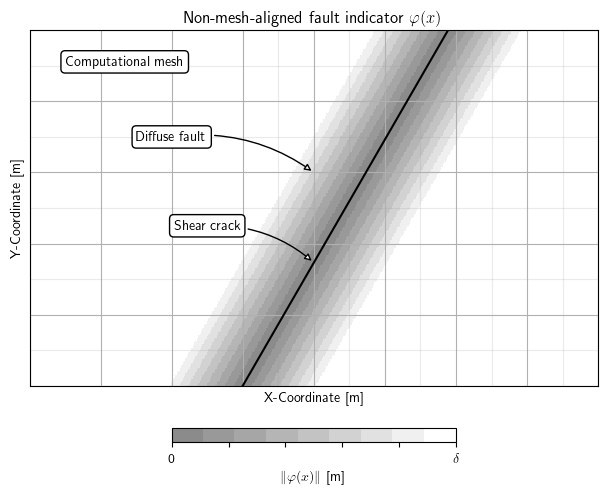

In [20]:
fig, img, AxCmap = PlotDomainCmap(X, Y, TiltSDFMaskOut, 
                   [r"Non-mesh-aligned fault indicator $\varphi(x)$", r"$\|\varphi(x)\|$ [m]"],
                   cmap, True)

plt.plot(xx,Tiltfunc(xx,theta = thetadeg*np.pi/180),"k-")


ColourBar = AxCmap.collections[-1].colorbar
ColourBar.ax.set_xticklabels([0,'','','','', r'$\delta$'])


#plt.contour(X,Y,TiltSDFMaskOut,levels=np.linspace(-Thickness, Thickness, 5, endpoint=True), colors="k", linestyles="--",linewidths=0.75)

"""
MarkerSpecs = {"marker":".","facecolors":"skyblue","edgecolors":"k","s":300,"zorder":9,"label":"Pos."}
plt.scatter(CoordinatesList[0],CoordinatesList[1], **MarkerSpecs)
MarkerSpecs.update({"facecolors":"gold","label":"Twin Pos."})
plt.scatter(TwinCoordinatesList[0],TwinCoordinatesList[1], **MarkerSpecs)
"""

plt.xlim(-1500,2500)
plt.ylim(0,2500)

#plt.legend(loc="lower right")

#%%%%%%%%%%%%%%%% Grid plot %%%%%%%%%%%%%%%%%%%%%%%%%%

ax = fig.gca()
plt.grid(b=True, which='major' )

minor_locator = AutoMinorLocator(2)
ax.xaxis.set_minor_locator(minor_locator)
ax.yaxis.set_minor_locator(minor_locator)

plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
#%%%%%%%%%%%%%%%% END: Grid plot %%%%%%%%%%%%%%%%%%%%%%%%%%
"""
[QuiverPlot(FaultDataObj) for FaultDataObj in ListFaultDataObj]
"""
#%%%%%%%%%%%%%%%% Distance \delta %%%%%%%%%%%%%%%%%%%%%%%%%%
"""
annotate_dim(ax,
             [xx[idx_Interest][0],Tiltfunc(xx[idx_Interest][0],theta = thetadeg*np.pi/180)],
             [CoordinatesList[0][0],CoordinatesList[1][0]],
             text="$\delta$")
"""
#%%%%%%%%%%%%%%%% END: Distance \delta %%%%%%%%%%%%%%%%%%%%%%%%%%

#%%%%%%%%%%%%%%%% +/- side of the fault %%%%%%%%%%%%%%%%%%%%%%%%%%
"""
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
ax.text(500, 2000, '"$+$" side', ha="center", va="center", size=12,
        bbox=bbox_props)
ax.text(3500, 750, '"$-$" side', ha="center", va="center", size=12,
        bbox=bbox_props)
"""
#%%%%%%%%%%%%%%%% END: +/- side of the fault %%%%%%%%%%%%%%%%%%%%%%%%%%
BoxAnnotation ="""Computational mesh"""
bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')

plt.text(-1250, 2250, BoxAnnotation, color='black', bbox=bbox)


plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off', 
    top='off', 
    labelbottom='off', 
    right='off', 
    left='off', 
    labelleft='off') # labels along the bottom edge are off


ax.annotate("Diffuse fault",
              xy=(500, 1500), xycoords='data',
              xytext=(-500, 1750), textcoords='data',
              va="center", ha="center",
              bbox=bbox,
              arrowprops=dict(arrowstyle="-|>",
                              connectionstyle="arc3,rad=-0.2",
                              fc="w"),
              )

ax.annotate("Shear crack",
              xy=(500, Tiltfunc(500,theta = thetadeg*np.pi/180)), xycoords='data',
              xytext=(-250, 1125), textcoords='data',
              va="center", ha="center",
              bbox=bbox,
              arrowprops=dict(arrowstyle="-|>",
                              connectionstyle="arc3,rad=-0.2",
                              fc="w"),
              )
plt.show()

/home/nico/miniconda3/envs/jane/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


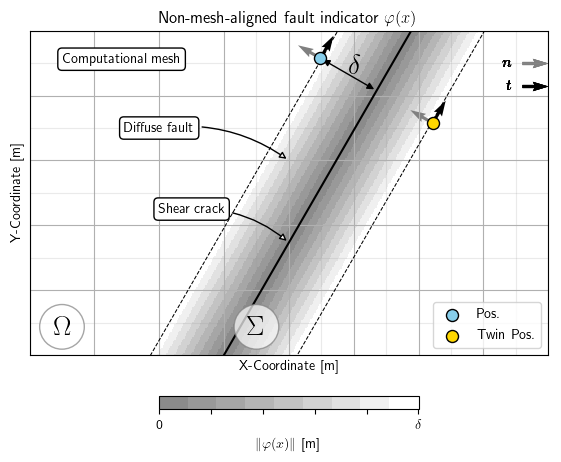

In [21]:
fig, img, AxCmap = PlotDomainCmap(X, Y, TiltSDFMaskOut, 
                   [r"Non-mesh-aligned fault indicator $\varphi(x)$", r"$\|\varphi(x)\|$ [m]"],
                   cmap, True,(5.5,5.5),100)

plt.plot(xx,Tiltfunc(xx,theta = thetadeg*np.pi/180),"k-")

ColourBar = AxCmap.collections[-1].colorbar

ColourBar.ax.set_xticklabels([0,"","","", "",r'$\delta$'])
plt.contour(X,Y,TiltSDFMaskOut,levels=np.linspace(-490, 490,2, endpoint=True), colors="k", linestyles="--",linewidths=0.75)


MarkerSpecs = {"marker":".","facecolors":"skyblue","edgecolors":"k","s":300,"zorder":9,"label":"Pos."}
plt.scatter(CoordinatesList[0],CoordinatesList[1], **MarkerSpecs)
MarkerSpecs.update({"facecolors":"gold","label":"Twin Pos."})
plt.scatter(TwinCoordinatesList[0],TwinCoordinatesList[1], **MarkerSpecs)


plt.xlim(-1500,2500)
plt.ylim(0,2500)

plt.legend(loc="lower right")

#%%%%%%%%%%%%%%%% Grid plot %%%%%%%%%%%%%%%%%%%%%%%%%%

ax = fig.gca()
plt.grid(b=True, which='major' ,zorder=10)

minor_locator = AutoMinorLocator(2)
ax.xaxis.set_minor_locator(minor_locator)
ax.yaxis.set_minor_locator(minor_locator)

plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2,zorder=10)
#%%%%%%%%%%%%%%%% END: Grid plot %%%%%%%%%%%%%%%%%%%%%%%%%%

[QuiverPlot(FaultDataObj) for FaultDataObj in ListFaultDataObj]

#%%%%%%%%%%%%%%%% Distance \delta %%%%%%%%%%%%%%%%%%%%%%%%%%

annotate_dim(ax,
             [xx[idx_Interest][0],Tiltfunc(xx[idx_Interest][0],theta = thetadeg*np.pi/180)],
             [CoordinatesList[0][0],CoordinatesList[1][0]],
             text="$\delta$",colorName = "k")

#%%%%%%%%%%%%%%%% END: Distance \delta %%%%%%%%%%%%%%%%%%%%%%%%%%

#%%%%%%%%%%%%%%%% +/- side of the fault %%%%%%%%%%%%%%%%%%%%%%%%%%
"""
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
ax.text(500, 2000, '"$+$" side', ha="center", va="center", size=12,
        bbox=bbox_props)
ax.text(3500, 750, '"$-$" side', ha="center", va="center", size=12,
        bbox=bbox_props)
"""
#%%%%%%%%%%%%%%%% END: +/- side of the fault %%%%%%%%%%%%%%%%%%%%%%%%%%
BoxAnnotation ="""Computational mesh"""
bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')

plt.text(-1250, 2250, BoxAnnotation, color='black', bbox=bbox)


plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off', 
    top='off', 
    labelbottom='off', 
    right='off', 
    left='off', 
    labelleft='off') # labels along the bottom edge are off


ax.annotate("Diffuse fault",
              xy=(500, 1500), xycoords='data',
              xytext=(-500, 1750), textcoords='data',
              va="center", ha="center",
              bbox=bbox,
              arrowprops=dict(arrowstyle="-|>",
                              connectionstyle="arc3,rad=-0.2",
                              fc="w"),
              )

ax.annotate("Shear crack",
              xy=(500, Tiltfunc(500,theta = thetadeg*np.pi/180)), xycoords='data',
              xytext=(-250, 1125), textcoords='data',
              va="center", ha="center",
              bbox=bbox,
              arrowprops=dict(arrowstyle="-|>",
                              connectionstyle="arc3,rad=-0.2",
                              fc="w"),
              )

bbox_props = dict(boxstyle="circle", fc="w", ec="0.5", alpha=0.7)


ax.annotate("$\Sigma$",
              xy=(250, Tiltfunc(125,theta = thetadeg*np.pi/180)), xycoords='data',
              va="center", ha="center", fontsize=20,
              bbox=bbox_props
              )

ax.annotate("$\Omega$",
              xy=(-1250, Tiltfunc(125,theta = thetadeg*np.pi/180)), xycoords='data',
              va="center", ha="center", fontsize=20,
              bbox=bbox_props
              )

plt.show()

In [67]:
# Tilted Field
SDF_Tilted_func = lambda theta:((-np.sin(theta)*X+np.cos(theta)*Y))

SDF_Tilted_full = SDF_Tilted_func(thetadeg*np.pi/180)

TiltSDFMaskOut = np.ma.masked_where(np.abs(SDF_Tilted_full) > Thickness, SDF_Tilted_full) 

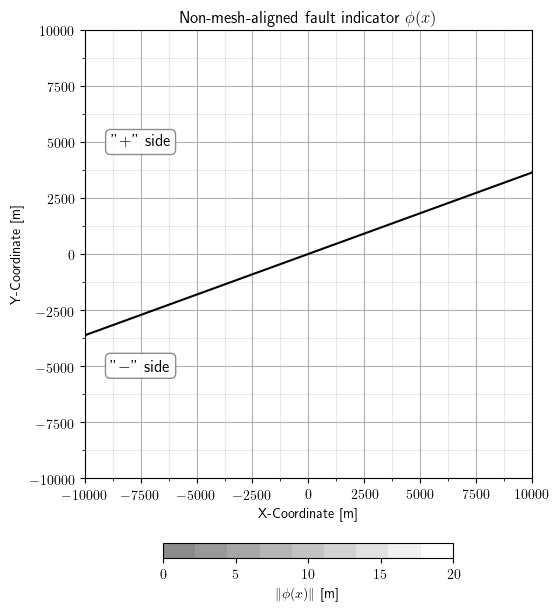

In [64]:
thetadeg=20
fig, img = PlotDomainCmap(X, Y, np.abs(TiltSDFMaskOut), 
           ["Non-mesh-aligned fault indicator $\phi(x)$", "$\|\phi(x)\|$ [m]"],
           cmap)
plt.plot(xx,Tiltfunc(xx,theta = thetadeg*np.pi/180),"k-")
   
#plt.contour(X,Y,TiltSDFMaskOut,levels=np.linspace(-5.e2, 5.e2, 5, endpoint=True), colors="k", linestyles="--",linewidths=0.75)



plt.xlim(-10000,10000)
plt.ylim(-10000,10000)

#plt.legend(loc="lower right")

#%%%%%%%%%%%%%%%% Grid plot %%%%%%%%%%%%%%%%%%%%%%%%%%

ax = fig.gca()
plt.grid(b=True, which='major' )

minor_locator = AutoMinorLocator(2)
ax.xaxis.set_minor_locator(minor_locator)
ax.yaxis.set_minor_locator(minor_locator)

plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
#%%%%%%%%%%%%%%%% END: Grid plot %%%%%%%%%%%%%%%%%%%%%%%%%%




#%%%%%%%%%%%%%%%% +/- side of the fault %%%%%%%%%%%%%%%%%%%%%%%%%%

bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
ax.text(-7500, 5000, '"$+$" side', ha="center", va="center", size=12,
        bbox=bbox_props)
ax.text(-7500, -5000, '"$-$" side', ha="center", va="center", size=12,
        bbox=bbox_props)

#%%%%%%%%%%%%%%%% END: +/- side of the fault %%%%%%%%%%%%%%%%%%%%%%%%%%


plt.show()